In [22]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [23]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D;
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
with open("tokenizerRed.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [25]:
with open("dados/tituloTratadoRed.csv", "r") as csvfile:
    titulos = np.genfromtxt(csvfile, delimiter=",")
    titulos = titulos.astype(np.int32)

In [26]:
with open("dados/conteudoTratadoRed.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [27]:
size = len(conteudos)

xTrain = conteudos[0:int(size*0.8)]
xTest = conteudos[int(size*0.8):]

yTrain = titulos[0:int(size*0.8)]
yTest = titulos[int(size*0.8):]

In [28]:
vocab = len(tokenizer.word_index)

In [29]:
vocab

19567

In [30]:
maxTitle = max(len(tokens) for tokens in titulos)
maxContent = max(len(tokens) for tokens in conteudos)

In [31]:
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [32]:
def Encoder(latentDim, encoderInputs):
    
  l1 = keras.models.Sequential([
    layers.Embedding(vocab, 128, input_length=maxContent),
    layers.Conv1D(128, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Conv1D(64, 3, activation="relu", strides=1, padding="same"),
    layers.MaxPooling1D(3),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  x = l1(encoderInputs)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(maxContent, 1))
encoder = Encoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2268, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 256)                  6707520   ['input_3[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_2[0][0]']        
                                                                                            

In [33]:
def Decoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(maxTitle, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((maxTitle, 1)),
    layers.Conv1DTranspose(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same", input_shape=(None, maxTitle))
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(2,))
decoder = Decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_3 (Sequential)   (None, 18, 1)             25399     
                                                                 
Total params: 25399 (99.21 KB)
Trainable params: 25399 (99.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
def reconstructionLoss(data, reconstructed):
  return keras.losses.binary_crossentropy(data, reconstructed)   

In [35]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
        -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
        axis=1
  )

In [36]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [37]:
print(xTrain.shape, "\n", yTrain.shape)

(396, 2268) 
 (396, 18)


In [38]:
xTrain = np.expand_dims(xTrain, -1).astype("float32") / vocab
yTrain = np.expand_dims(yTrain, -1).astype("float32") / vocab

In [39]:
xTest = np.expand_dims(xTest, -1).astype("float32") / vocab
yTest = np.expand_dims(yTest, -1).astype("float32") / vocab

In [40]:
print(xTrain.shape, "\n", yTrain.shape)

(396, 2268, 1) 
 (396, 18, 1)


In [41]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):

    x, y = data[0]

    with tf.GradientTape() as tape:
        
        zMean, zLogVar, z = self.encoder(x)
        reconstruction = self.decoder(z)

        ceLoss, klLoss, totalLoss = calcTotalLoss(y, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [42]:
data = [xTrain, yTrain]

In [45]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(data, epochs=10, batch_size=1)

Epoch 1/10
396/396 [==============================] - 24s 55ms/step - total_loss: 0.2915 - ce_loss: 0.2908 - kl_loss: 2.4037e-04
Epoch 2/10
396/396 [==============================] - 26s 67ms/step - total_loss: 0.2544 - ce_loss: 0.2543 - kl_loss: 9.3662e-06
Epoch 3/10
396/396 [==============================] - 29s 74ms/step - total_loss: 0.2467 - ce_loss: 0.2467 - kl_loss: 6.4890e-06
Epoch 4/10
396/396 [==============================] - 26s 65ms/step - total_loss: 0.2429 - ce_loss: 0.2429 - kl_loss: 3.9309e-06
Epoch 5/10
396/396 [==============================] - 20s 50ms/step - total_loss: 0.2427 - ce_loss: 0.2427 - kl_loss: 3.3028e-06
Epoch 6/10
396/396 [==============================] - 19s 48ms/step - total_loss: 0.2392 - ce_loss: 0.2392 - kl_loss: 9.8483e-07
Epoch 7/10
396/396 [==============================] - 19s 48ms/step - total_loss: 0.2394 - ce_loss: 0.2394 - kl_loss: 1.2706e-06
Epoch 8/10
396/396 [==============================] - 19s 48ms/step - total_loss: 0.2399 - ce_los

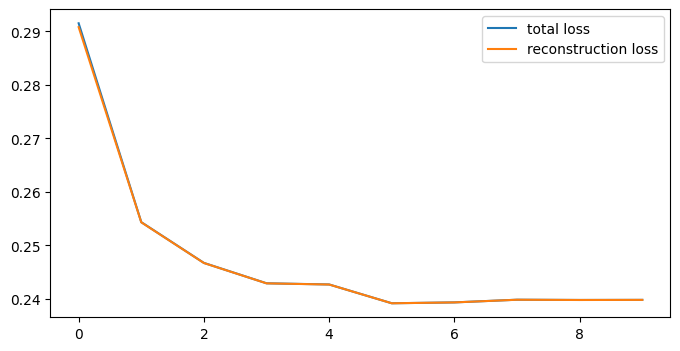

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

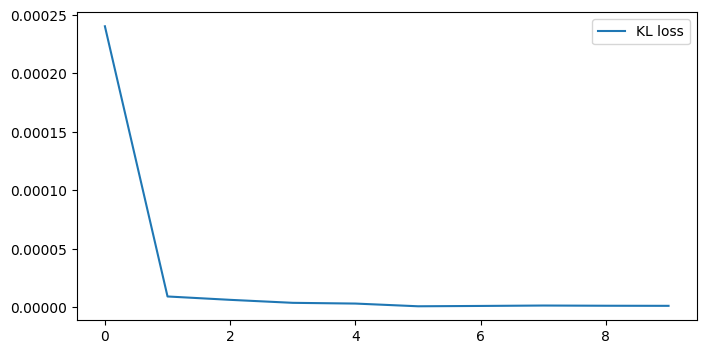

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

In [72]:
idx = 14
inputPredict = xTest[idx]
inputPredict = inputPredict.reshape(1, maxContent)

In [73]:
z = vae.encoder.predict([inputPredict])[2]

1/1 [==============================] - 0s 38ms/step


In [74]:
#z = np.random.normal(loc=0, scale=4, size=(1,2))

In [75]:
z

array([[-0.05489271, -0.82298034]], dtype=float32)

In [76]:
teste = vae.decoder.predict(z)

1/1 [==============================] - 0s 64ms/step


In [77]:
teste = teste.reshape(maxTitle)

In [78]:
teste*vocab

array([2854.0647  , 3647.08    , 2908.1406  , 2908.1406  , 2908.1406  ,
       2908.1406  , 2889.3613  , 2855.5322  , 2741.5059  , 2537.838   ,
       2022.5942  , 1430.8837  ,  662.1456  ,  313.1781  ,   56.80749 ,
         40.194645,    9.01384 ,   14.751162], dtype=float32)

In [79]:
prediction = (teste*vocab).tolist()
for x in range(maxTitle):
    prediction[x] = round(prediction[x])

predictionsText = tokenizer.sequences_to_texts([prediction])

In [80]:
content = xTest[idx].reshape(maxContent)
content = (content*vocab).tolist()

for x in range(maxContent):
    content[x] = round(content[x])

content = tokenizer.sequences_to_texts([content])

In [81]:
tittle = yTest[idx].reshape(maxTitle)
tittle = (tittle*vocab).tolist()

for x in range(maxTitle):
    tittle[x] = round(tittle[x])

tittle = tokenizer.sequences_to_texts([tittle])

In [82]:
tittle

['chamusca garante permanência no fortaleza após interesse do náutico']

In [83]:
content

['na tarde desta sexta feira o técnico do fortaleza marcelo chamusca confirmou que o náutico demonstrou interesse em sua contratação no entanto o treinador disse que tudo não passou de uma sondagem e que não tina interesse em deixar o leão do pici estou muito bem no fortaleza não quero sair vou continuar no clube porque meu foco é subir o time para a série b no tricolor chamusca foi vice campeão estadual e colocou o time na liderança do grupo a da série c do campeonato brasileiro ao todo o técnico comandou a equipe em 32 partidas conquistando 21 vitórias nove empates e sofrendo duas derrotas o próximo desafio de chamusca à frente do fortaleza ocorre nesta segunda feira 12 diante do águia de marabá no estádio presidente vargas às 21h30m chamusca realizou um treino de posicionamento na tarde de sexta feira no pici e repetiu a equipe titular que venceu o cuiabá na última rodada com ricardo tiago cametá eduardo luiz max oliveira e radar guto walfrido marcelinho paraíba e edinho robert e ro

In [84]:
predictionsText

['nba saldos enquete enquete enquete enquete finalizações emerson procurador urijah olho deram americana leve brasil contra da uma']